/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [23:43:58] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [23:43:58] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [23:43:58] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [23:43:58] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.12/site-packa

== Static PPO: pos=1, neg=-1 ==
== Sequential PPO: pos=1, neg=-1 ==
== Static PPO: pos=1, neg=-2 ==
== Sequential PPO: pos=1, neg=-2 ==
== Static PPO: pos=1, neg=-3 ==
== Sequential PPO: pos=1, neg=-3 ==
== Static PPO: pos=1, neg=-4 ==
== Sequential PPO: pos=1, neg=-4 ==
== Static PPO: pos=1, neg=-5 ==
== Sequential PPO: pos=1, neg=-5 ==
== Static PPO: pos=2, neg=-1 ==
== Sequential PPO: pos=2, neg=-1 ==
== Static PPO: pos=2, neg=-2 ==
== Sequential PPO: pos=2, neg=-2 ==
== Static PPO: pos=2, neg=-3 ==
== Sequential PPO: pos=2, neg=-3 ==
== Static PPO: pos=2, neg=-4 ==
== Sequential PPO: pos=2, neg=-4 ==
== Static PPO: pos=2, neg=-5 ==
== Sequential PPO: pos=2, neg=-5 ==
== Static PPO: pos=3, neg=-1 ==
== Sequential PPO: pos=3, neg=-1 ==
== Static PPO: pos=3, neg=-2 ==
== Sequential PPO: pos=3, neg=-2 ==
== Static PPO: pos=3, neg=-3 ==
== Sequential PPO: pos=3, neg=-3 ==
== Static PPO: pos=3, neg=-4 ==
== Sequential PPO: pos=3, neg=-4 ==
== Static PPO: pos=3, neg=-5 ==
== Sequential PP

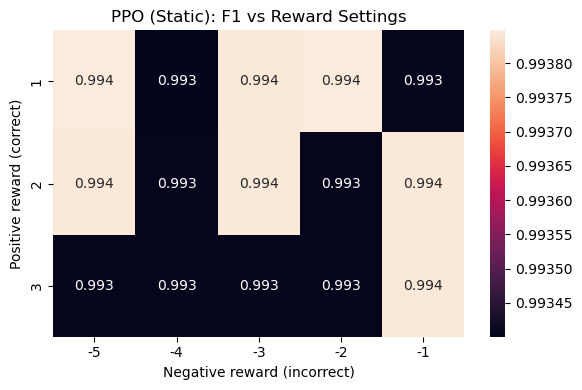

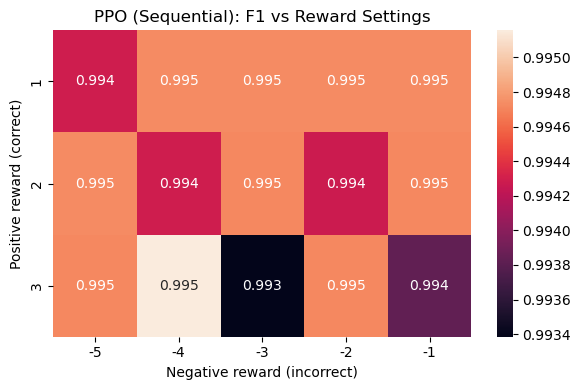

In [ ]:
import os, time, warnings, itertools
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd

import random
random.seed(42); np.random.seed(42)

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from imblearn.over_sampling import SMOTE

from xgboost import XGBClassifier

import gymnasium as gym
from gymnasium import spaces
from stable_baselines3 import PPO
from stable_baselines3.common.env_util import make_vec_env

import tensorflow as tf
tf.random.set_seed(42)
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv1D, LSTM, Bidirectional, Flatten, Input
from tensorflow.keras.optimizers import Adam

from pathlib import Path
candidates = [
    Path("Data/Hybrid_Augmented_TSAFE_Features.xlsx"),
    Path("../Data/Hybrid_Augmented_TSAFE_Features.xlsx"),
    Path("../data/Hybrid_Augmented_TSAFE_Features.xlsx"),
]
for p in candidates:
    if p.exists():
        file_path = str(p)
        break
else:
    raise FileNotFoundError(
        f"Could not find Excel. Tried: {candidates}. CWD={Path.cwd()}"
    )

df = pd.read_excel(file_path)

if 'Plant_Destination' not in df.columns:
    if {'Plant Code', 'Destination Port'}.issubset(df.columns):
        df['Plant_Destination'] = df['Plant Code'].astype(str) + ' | ' + df['Destination Port'].astype(str)
    else:
        raise ValueError("Cannot create 'Plant_Destination' because 'Plant Code' or 'Destination Port' is missing.")

cat_features = [
    'Origin Port','Carrier','Plant Code','Destination Port','Plant_Destination'
]

num_features = [
    'Unit quantity','Weight','TPT',
    'TPT_per_Unit','LeadTime_Deviation','Weight_per_Unit','log_UnitQty',
    'carrier_origin_risk','route_cum_late_rate','route_bb_mean','carrier_bb_mean',
    'route_orders_last7d','route_roll10_Weight_q90',
    'congestion_trend','Weight_vsCarrierMean','seq_pos_norm'
]

requested_cols = cat_features + num_features
missing = [c for c in requested_cols if c not in df.columns]
if missing:
    print(f"[WARN] Missing columns will be skipped: {missing}")
    cat_features = [c for c in cat_features if c in df.columns]
    num_features = [c for c in num_features if c in df.columns]

X = pd.get_dummies(df[cat_features + num_features], drop_first=False)
y = (df['Ship Late Day count'] > 0).astype(int)
X = X.replace([np.inf, -np.inf], np.nan)
X = X.fillna(X.median(numeric_only=True))
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42, stratify=y
)
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_res)
X_test_scaled  = scaler.transform(X_test)

def metrics_dict(y_true, y_score_or_pred):
    arr = np.asarray(y_score_or_pred).reshape(-1)
    if set(np.unique(arr)) <= {0,1}:
        y_pred = arr.astype(int)
    else:
        y_pred = (arr >= 0.5).astype(int)
    return {
        'Accuracy':  accuracy_score(y_true, y_pred),
        'Precision': precision_score(y_true, y_pred, average='weighted', zero_division=1),
        'Recall':    recall_score(y_true, y_pred, average='weighted', zero_division=1),
        'F1':        f1_score(y_true, y_pred, average='weighted', zero_division=1)
    }

xgb = GridSearchCV(
    estimator=XGBClassifier(random_state=42, eval_metric='logloss', use_label_encoder=False),
    param_grid={'n_estimators':[100],'max_depth':[3,5],'learning_rate':[0.1,0.05],'subsample':[0.8]},
    scoring='roc_auc', cv=3, n_jobs=-1
)
xgb.fit(X_train, y_train)
xgb_proba = xgb.best_estimator_.predict_proba(X_test)[:, 1]

def create_model(model_type, input_dim):
    model = Sequential()
    model.add(Input(shape=(input_dim, 1)))
    if model_type == 'CNN':
        model.add(Conv1D(64, 2, activation='relu'))
        model.add(Flatten())
    elif model_type == 'LSTM':
        model.add(LSTM(64, activation='tanh'))
    elif model_type == 'Bi-LSTM':
        model.add(Bidirectional(LSTM(64, activation='tanh')))
    elif model_type == 'Stacked LSTM':
        model.add(LSTM(64, activation='tanh', return_sequences=True))
        model.add(LSTM(32, activation='tanh'))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer=Adam(learning_rate=1e-3, clipnorm=1.0), loss='binary_crossentropy')
    return model

X_train_dl = X_train_scaled.reshape(-1, X_train_scaled.shape[1], 1)
X_test_dl  = X_test_scaled.reshape(-1,  X_test_scaled.shape[1],  1)

dl_models = ['CNN', 'LSTM', 'Bi-LSTM', 'Stacked LSTM']
dl_outputs = {}
for m in dl_models:
    mdl = create_model(m, X_train_dl.shape[1])
    mdl.fit(X_train_dl, y_train_res, epochs=10, batch_size=256, verbose=0)
    dl_outputs[m] = mdl.predict(X_test_dl, verbose=0).reshape(-1)

base_stack = np.vstack([xgb_proba, dl_outputs['CNN'], dl_outputs['LSTM'],
                        dl_outputs['Bi-LSTM'], dl_outputs['Stacked LSTM']]).T.astype(np.float32)
ppo_base = MinMaxScaler().fit_transform(base_stack).astype(np.float32)  # in [0,1]
labels_test = y_test.values.astype(int)

class PPOStaticEnv(gym.Env):
    """
    Row-wise PPO. Observation: (5,) of stacked model outputs in [0,1].
    Action: {0,1}. Reward: +pos if correct else neg.
    """
    metadata = {"render_modes": []}
    def __init__(self, inputs, labels, pos_reward=1.0, neg_reward=-5.0):
        super().__init__()
        self.inputs = inputs
        self.labels = labels.astype(int)
        self.n = len(labels)
        self.pos_reward = float(pos_reward)
        self.neg_reward = float(neg_reward)
        self.observation_space = spaces.Box(low=0, high=1, shape=(inputs.shape[1],), dtype=np.float32)
        self.action_space = spaces.Discrete(2)
        self.idx = 0

    def reset(self, seed=None, options=None):
        super().reset(seed=seed)
        self.idx = 0
        return self.inputs[self.idx], {}

    def step(self, action):
        y = self.labels[self.idx]
        reward = self.pos_reward if action == y else self.neg_reward
        self.idx += 1
        terminated = self.idx >= self.n
        obs = np.zeros(self.inputs.shape[1], dtype=np.float32) if terminated else self.inputs[self.idx]
        return obs, float(reward), terminated, False, {}

def build_sequential_frame(df_src, test_index, y_vec, stack_probas):
    tfm = df_src.loc[test_index, ['Order Date','Origin Port','Destination Port','Carrier']].copy()
    tfm['Order Date'] = pd.to_datetime(tfm['Order Date'])
    tfm['y'] = y_vec.astype(int)
    # attach columns for completeness (unused later except sorting)
    cols = ['xgb','CNN','LSTM','Bi-LSTM','Stacked LSTM']
    for i, c in enumerate(cols):
        tfm[c] = stack_probas[:, i]
    tfm['route_key'] = (
        tfm['Origin Port'].astype(str) + ' | ' +
        tfm['Destination Port'].astype(str) + ' | ' +
        tfm['Carrier'].astype(str)
    )
    tfm = tfm.sort_values('Order Date').reset_index(drop=True)
    # Produce episodes as contiguous same-route segments
    route_sorted = tfm['route_key'].values
    episodes = []
    start = 0
    for i in range(1, len(tfm) + 1):
        if i == len(tfm) or route_sorted[i] != route_sorted[i-1]:
            episodes.append(slice(start, i))
            start = i
    return tfm, episodes

class PPOSequentialEnv(gym.Env):
    """
    Sequential PPO. Observation = [base_inputs(5), time_sin, time_cos, last_K_actions(K)]
    Action: {0,1}
    Reward: +pos if correct else neg   (symmetric version for clean sensitivity)
    """
    metadata = {"render_modes": []}
    def __init__(self, base_inputs, labels, episodes, pos_reward=1.0, neg_reward=-5.0, K=5):
        super().__init__()
        self.base_inputs = base_inputs
        self.labels = labels.astype(int)
        self.episodes = episodes
        self.pos_reward = float(pos_reward)
        self.neg_reward = float(neg_reward)
        self.K = K
        self.obs_dim = 5 + 2 + K
        self.observation_space = spaces.Box(low=-np.inf, high=np.inf, shape=(self.obs_dim,), dtype=np.float32)
        self.action_space = spaces.Discrete(2)
        self._ep_idx = -1
        self._indices = None
        self._t = None
        self._last_actions = None

    def _time_feats(self, t, T):
        pos = (t / max(T - 1, 1))
        return np.array([np.sin(2*np.pi*pos), np.cos(2*np.pi*pos)], dtype=np.float32)

    def _obs(self):
        T = len(self._indices)
        idx = self._indices[self._t]
        x = self.base_inputs[idx]
        time_feat = self._time_feats(self._t, T)
        return np.concatenate([x, time_feat, self._last_actions], axis=0).astype(np.float32)

    def reset(self, seed=None, options=None):
        super().reset(seed=seed)
        self._ep_idx = (self._ep_idx + 1) % len(self.episodes)
        sl = self.episodes[self._ep_idx]
        self._indices = np.arange(sl.start, sl.stop, dtype=int)
        self._t = 0
        self._last_actions = np.zeros(self.K, dtype=np.float32)
        return self._obs(), {}

    def step(self, action):
        idx = self._indices[self._t]
        y = self.labels[idx]
        reward = self.pos_reward if action == y else self.neg_reward

        # update memory
        self._last_actions = np.roll(self._last_actions, -1)
        self._last_actions[-1] = float(action)

        # advance
        self._t += 1
        terminated = self._t >= len(self._indices)
        truncated = False
        obs = np.zeros(self.obs_dim, dtype=np.float32) if terminated else self._obs()
        return obs, float(reward), terminated, truncated, {}

test_idx = X_test.index

tmp_frame = pd.DataFrame({
    'xgb': ppo_base[:,0],
    'CNN': ppo_base[:,1],
    'LSTM': ppo_base[:,2],
    'Bi-LSTM': ppo_base[:,3],
    'Stacked LSTM': ppo_base[:,4],
}, index=test_idx)

seq_frame, episodes = build_sequential_frame(df, test_idx, y_test.values, tmp_frame[['xgb','CNN','LSTM','Bi-LSTM','Stacked LSTM']].values)

seq_base_inputs = seq_frame[['xgb','CNN','LSTM','Bi-LSTM','Stacked LSTM']].values.astype(np.float32)
seq_labels_sorted = seq_frame['y'].values.astype(int)

def train_static_ppo(pos_reward, neg_reward, total_timesteps=50_000, seed=42):
    env = make_vec_env(lambda: PPOStaticEnv(ppo_base, labels_test, pos_reward, neg_reward), n_envs=1)
    model = PPO("MlpPolicy", env, verbose=0, seed=seed)
    t0 = time.time()
    model.learn(total_timesteps=total_timesteps)
    elapsed = round(time.time() - t0, 2)

    eval_env = PPOStaticEnv(ppo_base, labels_test, pos_reward, neg_reward)
    obs, _ = eval_env.reset()
    preds = []
    done = False
    while not done:
        action, _ = model.predict(obs, deterministic=True)
        preds.append(int(action))
        obs, _, done, _, _ = eval_env.step(action)
    mets = metrics_dict(labels_test, np.array(preds))
    mets.update({'Time (s)': elapsed})
    return mets

def train_sequential_ppo(pos_reward, neg_reward, total_timesteps=80_000, seed=42, K=5):
    env = make_vec_env(lambda: PPOSequentialEnv(seq_base_inputs, seq_labels_sorted, episodes,
                                                pos_reward, neg_reward, K=K), n_envs=1)
    model = PPO("MlpPolicy", env, verbose=0, seed=seed)
    t0 = time.time()
    model.learn(total_timesteps=total_timesteps)
    elapsed = round(time.time() - t0, 2)

    eval_env = PPOSequentialEnv(seq_base_inputs, seq_labels_sorted, episodes, pos_reward, neg_reward, K=K)
    obs, _ = eval_env.reset()
    preds = []
    visited = 0
    while True:
        action, _ = model.predict(obs, deterministic=True)
        preds.append(int(action))
        obs, _, terminated, truncated, _ = eval_env.step(action)
        if terminated:
            visited += 1
            if visited >= len(episodes):
                break
            obs, _ = eval_env.reset()
    preds = np.array(preds[:len(seq_labels_sorted)])
    mets = metrics_dict(seq_labels_sorted, preds)
    mets.update({'Time (s)': elapsed})
    return mets

pos_grid = [1, 2, 3]
neg_grid = [-1, -2, -3, -4, -5]

results_static = []
results_sequential = []

TIMESTEPS_STATIC = 50_000
TIMESTEPS_SEQ    = 80_000

for pos_r, neg_r in itertools.product(pos_grid, neg_grid):
    print(f"== Static PPO: pos={pos_r}, neg={neg_r} ==")
    mets_s = train_static_ppo(pos_r, neg_r, total_timesteps=TIMESTEPS_STATIC)
    mets_s.update({'Variant':'PPO (Static)', 'pos_reward':pos_r, 'neg_reward':neg_r})
    results_static.append(mets_s)

    print(f"== Sequential PPO: pos={pos_r}, neg={neg_r} ==")
    mets_q = train_sequential_ppo(pos_r, neg_r, total_timesteps=TIMESTEPS_SEQ)
    mets_q.update({'Variant':'PPO (Sequential)', 'pos_reward':pos_r, 'neg_reward':neg_r})
    results_sequential.append(mets_q)

df_static = pd.DataFrame(results_static)
df_sequential = pd.DataFrame(results_sequential)

print("\n=== Reward Sensitivity: PPO (Static) ===")
print(df_static.sort_values(['F1','Accuracy'], ascending=False).reset_index(drop=True))

print("\n=== Reward Sensitivity: PPO (Sequential) ===")
print(df_sequential.sort_values(['F1','Accuracy'], ascending=False).reset_index(drop=True))

df_static.to_csv("reward_sensitivity_static.csv", index=False)
df_sequential.to_csv("reward_sensitivity_sequential.csv", index=False)

def heatmap_metric(df, metric='F1', title='PPO Static: F1 vs Rewards'):
    pivot = df.pivot(index='pos_reward', columns='neg_reward', values=metric)
    plt.figure(figsize=(6,4))
    sns.heatmap(pivot, annot=True, fmt=".3f", cbar=True)
    plt.title(title)
    plt.xlabel("Negative reward (incorrect)")
    plt.ylabel("Positive reward (correct)")
    plt.tight_layout()
    plt.show()

heatmap_metric(df_static, metric='F1', title='PPO (Static): F1 vs Reward Settings')
heatmap_metric(df_sequential, metric='F1', title='PPO (Sequential): F1 vs Reward Settings')
